# Preprocessing the data of scATAC-seq with Epiverse

A crucial part of every single-cell analysis is the removal of low-quality cells which can distort downstream analyses outcomes. scATAC-seq data, having only 1-10% of open chromatin regions detected in each cell, is even more sparse than scRNA-seq data [Chen et al., 2019](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1854-5). Therefore, quality issues such as low sequencing depth per cell or poor signal-to-noise ratio can lead to uninformative observations (cells). Another challenge is the detection of multiplets (two or more cells profiled together). 

An easy and efficient scATAC-seq QC framework is indispensable. Here, we introduce Epiverse, which can complete single-cell ATAC-seq QC and obtain high-quality visualisation picture.



In [4]:
import Epiverse as ev
import omicverse as ov
import scanpy as sc
from muon import atac as ac
ov.ov_plot_set()

## Data downloaded

Here, we used the official [cellranger-atac example data](https://www.10xgenomics.com/resources/datasets/10k-human-pbmcs-atac-v2-chromium-controller-2-standard) from 10x genomics for quality control analyses.

In [ ]:
!wget -p data https://cf.10xgenomics.com/samples/cell-atac/2.1.0/10k_pbmc_ATACv2_nextgem_Chromium_X/10k_pbmc_ATACv2_nextgem_Chromium_X_fragments.tsv.gz
!wget -p data https://cf.10xgenomics.com/samples/cell-atac/2.1.0/10k_pbmc_ATACv2_nextgem_Chromium_X/10k_pbmc_ATACv2_nextgem_Chromium_X_fragments.tsv.gz.tbi
!wget -p data https://cf.10xgenomics.com/samples/cell-atac/2.1.0/10k_pbmc_ATACv2_nextgem_Chromium_X/10k_pbmc_ATACv2_nextgem_Chromium_X_filtered_peak_bc_matrix.h5 

In [2]:
adata=sc.read_10x_h5('data/10k_pbmc_ATACv2_nextgem_Chromium_X_filtered_peak_bc_matrix.h5',
                     gex_only=False)
adata.uns['files']={'fragments': 'data/10k_pbmc_ATACv2_nextgem_Chromium_X_fragments.tsv.gz'}

reading data/10k_pbmc_ATACv2_nextgem_Chromium_X_filtered_peak_bc_matrix.h5
 (0:00:03)


We need to download the reference note file, epiverse provides a way to download the gtf of T2T-CHM13, about the other gtf file you can download on [Gencode](https://www.gencodegenes.org/human/)

In [5]:
ev.utils.download_gene_annotation_file(download_file='gtf')

......Gene Annotation File download start: chm13v2.0_RefSeq_Liftoff_v4
......Downloading dataset save to gtf/chm13v2.0_RefSeq_Liftoff_v4.gtf.gz
......[chm13v2.0_RefSeq_Liftoff_v4 Size of file]: 7.23 MB
......[Downloader]: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%
.......Finish！10.978982925415039.2f s
......Gene Annotation File download start: GRCH38.v44.basic.annotation.gtf.gz
......Downloading dataset save to gtf/GRCH38.v44.basic.annotation.gtf.gz.gtf.gz
......[GRCH38.v44.basic.annotation.gtf.gz Size of file]: 2.82 MB
......[Downloader]: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%
.......Finish！7.78049898147583.2f s
......Gene Annotation File download finished!


## Calculating QC metrics

To detect low quality cells, we need to define metrics, that allow us to separate high quality from low-quality cells. Here is an overview of the primary QC metrics used across multiple scATAC-seq processing pipelines:

- total_fragment_counts: Total number of fragments per cell representing cellular sequencing depth. This metric is analogous to the number of total counts in scRNA-seq data.
- tss_enrichment: Transcription start site (TSS) enrichment score, which is the ratio of fragments centered at the TSS to fragments in TSS-flanking regions. This metric can be interpreted as a signal-to noise ratio of each cell.
- n_features_per_cell: The number of peaks with non-zero counts in each cell. This metric is analogous to the number of genes detected in scRNA-seq data.
- nucleosome_signal: The nucleosome signal refers to the ratio of mono-nucleosomal to nucloesome-free fragments and can also be interpreted as a signal-to-noise ratio in each cell (more details below).

In [3]:
adata,tss=ev.pp.cal_qc(adata = adata, 
                    fragments_file = adata.uns['files']['fragments'],
                    fragments_tbi_file = 'data/10k_pbmc_ATACv2_nextgem_Chromium_X_fragments.tsv.gz.tbi',
                    Number_of_fragments_to_count = 10e3*adata.n_obs,
                    n_tss=3000,
                    RefSeq_file = 'gtf/GRCH38.v44.basic.annotation.gtf.gz',
                    )

......Calculate QC metrics
......Log-transform total counts
......Calculate the nucleosome signal across cells


Reading Fragments: 100%|███████████████████████████████████████████████████████████████████████████████| 102730000/102730000 [03:31<00:00, 485502.10it/s]

Added a "nucleosome_signal" column to the .obs slot of the AnnData object


......Process the gene annotation file
......Calculate the TSS enrichment score


Fetching Regions...: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 2998/2998 [00:13<00:00, 214.24it/s]


Added a "tss_score" column to the .obs slot of the AnnData object
......Calculate QC metrics successfully


In [11]:
adata.write_h5ad('data/adata_qc_raw.h5ad',compression='gzip')
tss.write_h5ad('data/adata_tss.h5ad',compression='gzip')

In [2]:
adata=sc.read('data/adata_qc_raw.h5ad')
tss=sc.read('data/adata_tss.h5ad')

For the nucleosome signal, the default number of fragments n per cell used to calculate the metric is 10e4*n_cells. Since this takes long to calculate, we reduce it by a factor of 10, which still returns a good estimate. However, in a production pipeline we would still recommend to keep the default.



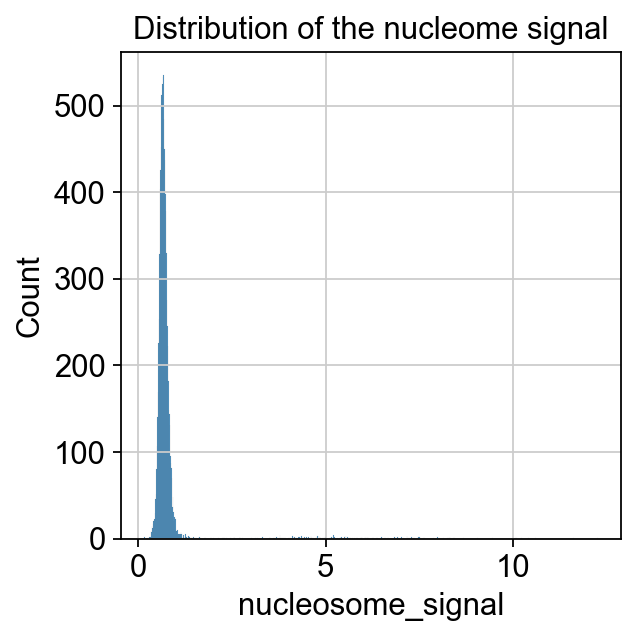

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(adata.obs, x="nucleosome_signal")
plt.title("Distribution of the nucleome signal")
plt.show()

# Alternatively as a violin plot (uncomment to plot)
# sc.pl.violin(atac, "nucleosome_signal")

The obtained scores in this data set range from 0 to 15. As a rule of thumb, previous analysis projects chose a threshold larger than 2 to label low quality cells. Let’s now take a closer look at cells with a high versus low nucleosome signal metric. To do so, we add a column to atac.obs, which contains a category for the two classes.

In [6]:
# Add group labels for above and below the nucleosome signal threshold
nuc_signal_threshold = 2
adata.obs["nuc_signal_filter"] = [
    "NS_FAIL" if ns > nuc_signal_threshold else "NS_PASS"
    for ns in adata.obs["nucleosome_signal"]
]

# Print number cells not passing nucleosome signal threshold
adata.obs["nuc_signal_filter"].value_counts()

NS_PASS    9974
NS_FAIL     299
Name: nuc_signal_filter, dtype: int64

We can see, this sample only contains 299 barcodes with a higher nucleosome signal than 2.

Next, we plot the distribution of fragment lengths per group of cells. To speed up the generation of the plotting, we analyze fragments mapping to a certain region on chromosome 1 by setting region="chr1:1-2000000".

Fetching Regions...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


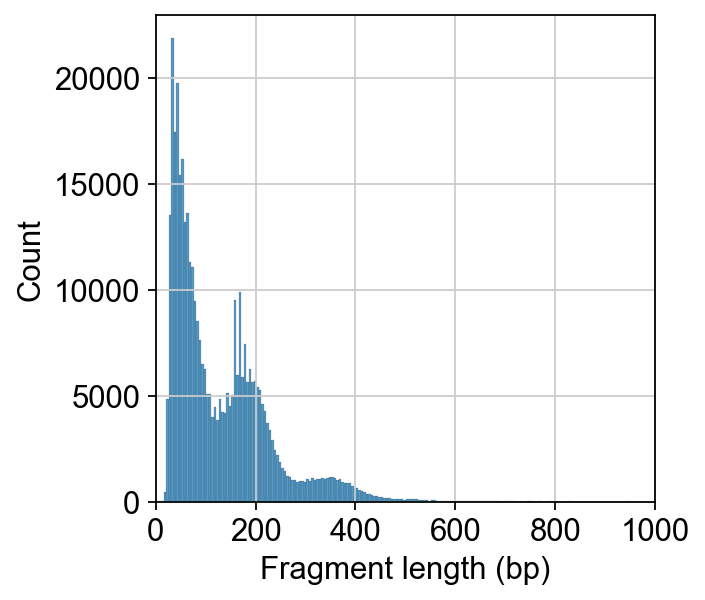

Fetching Regions...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


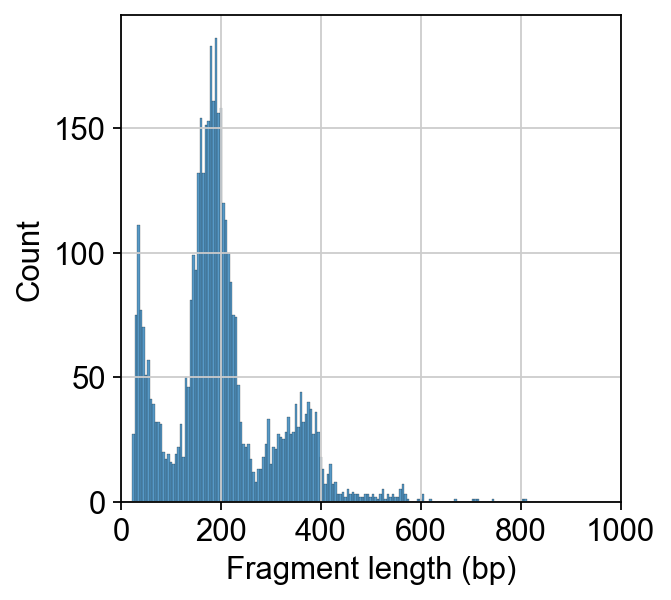

In [7]:
# Plot fragment size distribution
from muon import atac as ac
ac.pl.fragment_histogram(
    adata[adata.obs["nuc_signal_filter"] == "NS_PASS"], region="chr1:1-2000000",
    show=False,
)
plt.show()
ac.pl.fragment_histogram(
    adata[adata.obs["nuc_signal_filter"] == "NS_FAIL"], region="chr1:1-2000000",
    show=False,
)

In the first histograms, we see periodically decreasing peaks corresponding to fragment lengths in nucleosome-free regions (<100bp), mono-, di- and a small tri-nucleosomal length. In high quality ATAC-seq data we expect an enrichment of fragments from nucleosome-free regions compared to fragments with mono- and multi-nucleosomal lengths (this ratio is calculated as the nucleosome signal). In the second plot this ratio sub-optimal, and we exclude these cells. However, the low number of cells with a high nucleosome signal indicate that we are working with data with overall good quality

......Plot the distribution of the TSS score


(<Figure size 640x320 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Full range'}, xlabel='tss_score', ylabel='Count'>,
        <AxesSubplot: title={'center': 'Up to 99.5% percentile'}, xlabel='tss_score', ylabel='Count'>],
       dtype=object))

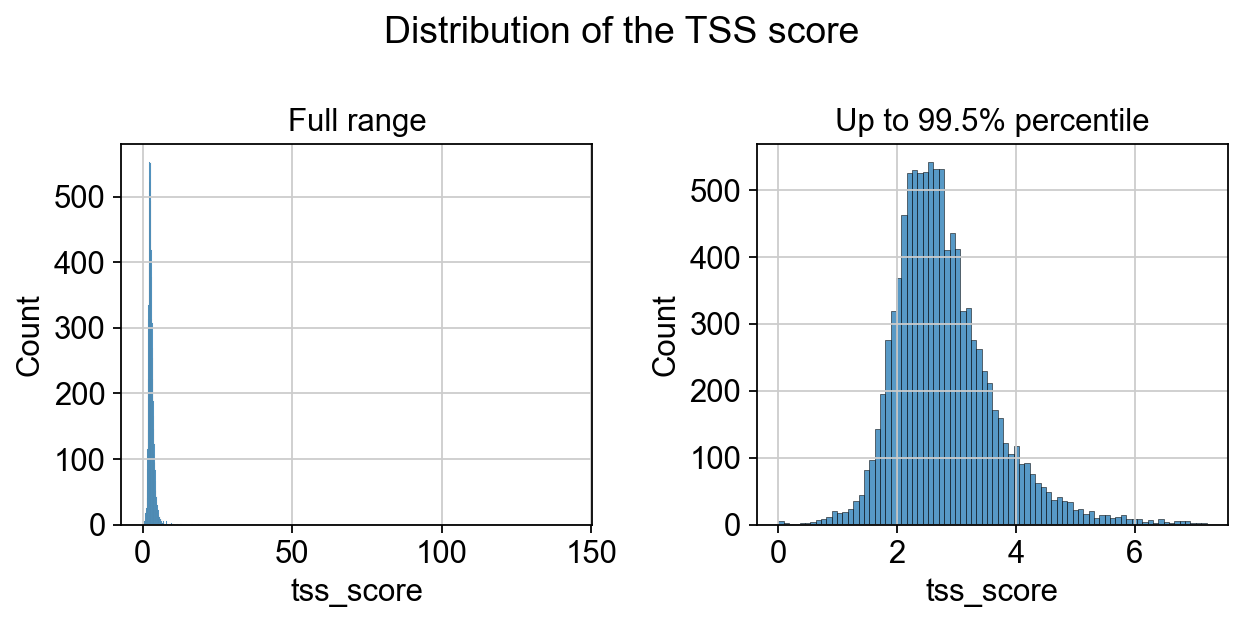

In [8]:
ev.pp.plot_tss(adata)

The histograms show that there are a few outliers with extremely high TSS scores and a small peak of barcodes with low TSS scores. Both are observations we would like to filter out.

To understand the TSS score better, we plot the number of transposition events (fragment ends) up- and downstream of transcription start sites. We make use of the plotting function ac.pl.tss_enrichment available in muon and input the newly created tss object. To compare the enrichment profile corresponding to high and low TSS scores, we add a new column to tss.obs containing "TSS_PASS" or "TSS_FAIL" depending on a threshold that separates observations in the small peak of low scores we identified above.

In [12]:
tss_threshold = 1
tss.obs["tss_filter"] = [
    "TSS_FAIL" if score < tss_threshold else "TSS_PASS"
    for score in adata.obs["tss_score"]
]

# Print number cells not passing nucleosome signal threshold
tss.obs["tss_filter"].value_counts()

TSS_PASS    10206
TSS_FAIL       67
Name: tss_filter, dtype: int64

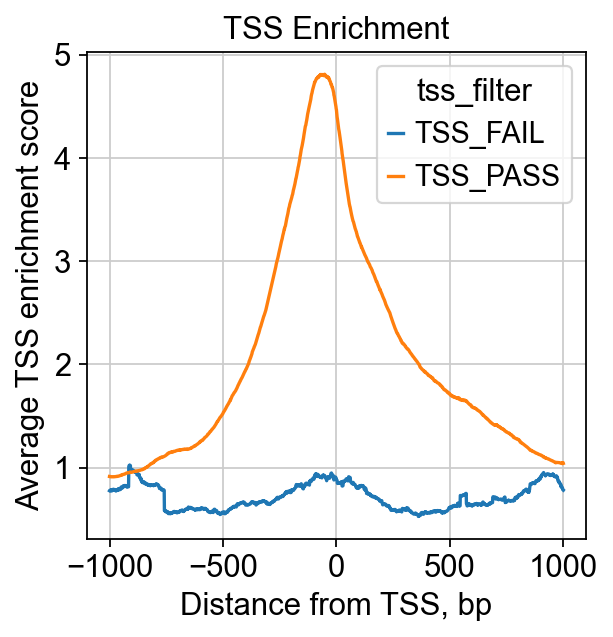

In [13]:
ac.pl.tss_enrichment(tss, color="tss_filter")

To identify the lower bounds of QC metrics, we create one of the most common visualizations in scATAC data to identify empty droplets and/or low quality cells. This is a scatter plot showing the TSS score over the log of the total counts.

We also added lines of suitable thresholds that we identified by looking at this and additional plots shown below.

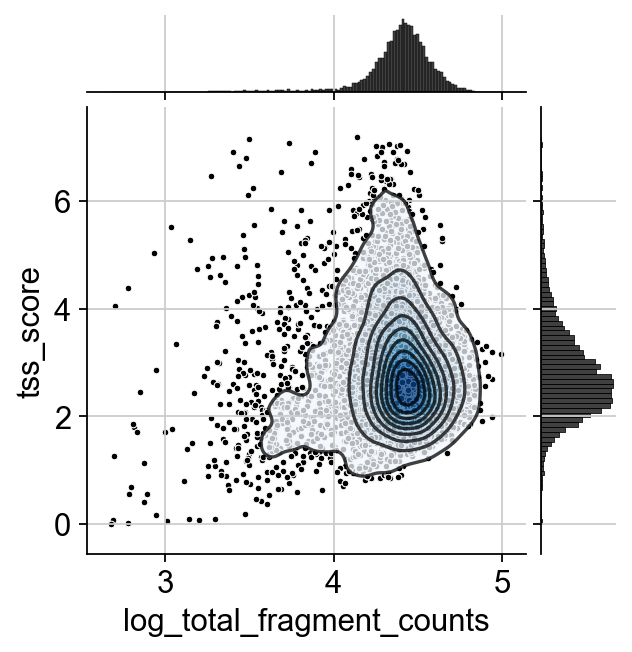

In [16]:
ev.pp.plot_fragment_counts(adata,figsize=(4,4))

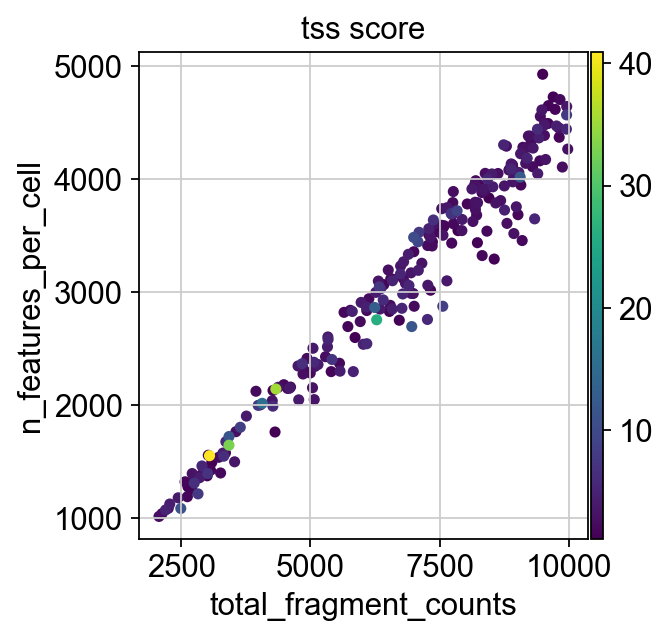

In [22]:
# Scatter plot total fragment count by number of features

p2 = sc.pl.scatter(
    adata[adata.obs.log_total_fragment_counts < 4],
    x="total_fragment_counts",
    y="n_features_per_cell",
    size=100,
    color="tss_score",
    show=False,
)

plt.show()

Let’s also get an idea for the number of features that barcodes with a total number of fragments in that range have. We added lines for a total fragment count of 3,000, which represents an intermediate value of the suggested thresholds above.

## Perform filtering

To summarize the outcome of our analysis thresholds:

- Total number of fragment counts per cell: > 10000 (log>4) and < 100000 (log<5)
- Number of features per cell: > 3000 (corresponding to the total fragment counts of 5000)
- TSS score: > 1 and < 50
- Nucleosome signal: < 2

In [23]:
adata = ev.pp.filter_qc(adata, 
                tresh={'fragment_counts_min': 2000,
                'fragment_counts_max': 100000,
                'features_per_cell_min': 3000, # There is a nearly linear relationship of the total fragment count with the number of features per cell.
                'TSS_score_min': 1,
                'TSS_score_max': 50,
                'Nucleosome_singal_max': 2,
                'cells_by_counts_min': 15
                })

Total number of cells: 9918
Total number of peaks: 164486
......Number of cells after filtering on total_fragment_counts: 9918
......Number of cells after filtering on n_features_per_cell: 9814
......Number of cells after filtering on tss_score: 9814
......Number of cells after filtering on nucleosome_signal: 9814
......filtered out peaks that are detected in less than 15 cells
......Number of peaks after filtering on cells_by_counts_min: 164486


In [24]:
adata

AnnData object with n_obs × n_vars = 9814 × 164486
    obs: 'n_features_per_cell', 'total_fragment_counts', 'log_total_fragment_counts', 'nucleosome_signal', 'tss_score', 'nuc_signal_filter'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'files'